# 교차 검증과 그리드 서치

## 검증 세트

In [27]:
import pandas as pd

wine = pd.read_csv('https://bit.ly/wine_csv_data')

In [28]:

data = wine[['alcohol', 'sugar', 'pH']].to_numpy()
target = wine['class'].to_numpy()

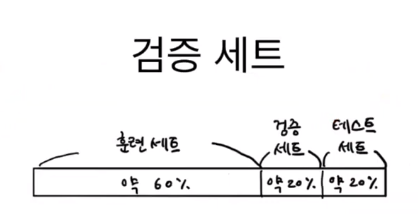

In [33]:
from sklearn.model_selection import train_test_split

train_input, test_input, train_target, test_target = train_test_split(
    data, target, test_size=0.2, random_state=42)


In [35]:
sub_input, val_input, sub_target, val_target = train_test_split(
    train_input, train_target, test_size=0.2, random_state=42)

In [36]:
print(sub_input.shape,val_input.shape)

(4157, 3) (1040, 3)


In [37]:
from sklearn.tree import DecisionTreeClassifier

dt=DecisionTreeClassifier()
dt.fit(sub_input,sub_target)
print(dt.score(sub_input,sub_target))
print(dt.score(val_input,val_target))

0.9971133028626413
0.864423076923077


## 교차 검증

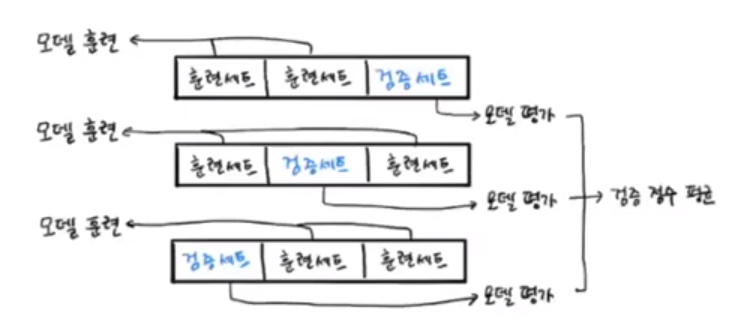

In [38]:
from sklearn.model_selection import cross_validate

scores=cross_validate(dt,train_input,train_target)
print(scores)

{'fit_time': array([0.00997257, 0.00796437, 0.00797892, 0.00698018, 0.00698113]), 'score_time': array([0.00199747, 0.        , 0.00099754, 0.        , 0.00099754]), 'test_score': array([0.87403846, 0.84903846, 0.87584216, 0.85659288, 0.83638114])}


In [40]:
import numpy as np

print(np.mean(scores['test_score']))

0.8583786184941141


## 분할기를 사용한 교차 검증

In [49]:
# 보통은 5개 폴드, cv=10 10개 폴더, kfold 회귀 모형일 경우, stratifiedkfold 분류 모형일 경우

from sklearn.model_selection import StratifiedKFold

scores=cross_validate(dt,train_input,train_target,cv=StratifiedKFold())
print(np.mean(scores['test_score']))

0.8583791737617531


In [47]:
splitter=StratifiedKFold(n_splits=10,shuffle=True,random_state=42)

scores=cross_validate(dt,train_input,train_target,cv=splitter)
print(np.mean(scores['test_score']))

0.8581888246628132


# 하이퍼파라미터 튜닝

## 그리드 서치

In [51]:
# 대부분 그리드 서치 사용한다.
from sklearn.model_selection import GridSearchCV

params={'min_impurity_decrease':[0.0001,0.0002,0.0003,0.0004,0.0005]}

gs=GridSearchCV(DecisionTreeClassifier(random_state=42),params,n_jobs=-1)
gs.fit(train_input,train_target)

dt=gs.best_estimator_
print(dt.score(train_input,train_target))

print(gs.best_params_)

print(gs.cv_results_['mean_test_score'])

0.9615162593804117
{'min_impurity_decrease': 0.0001}
[0.86819297 0.86453617 0.86492226 0.86780891 0.86761605]


## 확률 분포 선택

In [55]:
from scipy.stats import uniform, randint # 실수  균등분포 샘플링

rgen=randint(0,10)
rgen.rvs(10)

array([3, 3, 7, 2, 1, 7, 0, 9, 6, 2])

In [57]:
np.unique(rgen.rvs(1000),return_counts=True)

(array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9]),
 array([124,  97,  98, 107,  93, 100,  98,  98,  88,  97], dtype=int64))

In [58]:
ugen=uniform(0,1)
ugen.rvs(10)

array([0.93274939, 0.22093426, 0.35462818, 0.15253741, 0.15622762,
       0.63096025, 0.58909571, 0.84058294, 0.20746372, 0.16925884])

## 랜덤 서치

In [59]:
params = {'min_impurity_decrease': uniform(0.0001, 0.001),
          'max_depth': randint(20, 50),
          'min_samples_split': randint(2, 25),
          'min_samples_leaf': randint(1, 25),
          }

In [60]:
from sklearn.model_selection import RandomizedSearchCV

gs=RandomizedSearchCV(DecisionTreeClassifier(random_state=42),params,
                     n_iter=100,n_jobs=-1,random_state=42)
# n_iter 모델을 만들갯수 
# 샘플링 100번

gs.fit(train_input,train_target)

print(gs.best_params_)

{'max_depth': 39, 'min_impurity_decrease': 0.00034102546602601173, 'min_samples_leaf': 7, 'min_samples_split': 13}


In [61]:
print(np.max(gs.cv_results_['mean_test_score']))

0.8695428296438884


In [62]:
dt=gs.best_estimator_
print(dt.score(test_input,test_target))

0.86


In [ ]:
# test 데이터는 최종 시행 전에 해야한다. 그래서 검증데이터를 따로 만들어서 하는것이 좋다.